In [1]:
import cv2
import json
import numpy as np
import openvino as ov
import matplotlib.pyplot as plt

In [2]:
core = ov.Core()

In [3]:
colormap = np.array([[128, 64, 128], [232, 35, 244], [70, 70, 70], [156, 102, 102],
                     [153, 153, 190], [153, 153, 153], [30, 170, 250], [0, 220, 220],
                     [35, 142, 107], [152, 251, 152], [180, 130, 70], [60, 20, 220],
                     [0, 0, 255], [142, 0, 0], [70, 0, 0], [100, 60, 0],
                     [100, 80, 0], [230, 0, 0], [32, 11, 119], [255, 255, 255]])

In [4]:
colormap.shape

(20, 3)

In [5]:
model = core.read_model(model='./models/semantic-segmentation-adas-0001.xml')

In [6]:
compiled_model = core.compile_model(model=model, device_name='CPU')
input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output(0)
N, C, H, W = input_layer_ir.shape

### Classes

Road, Sidewalk, Building, Wall, Fence, Pole, Traffic Light, Traffic Sign, Vegetation, Terrain, Sky, Person, Rider, Car, Truck, Bus, Train, Motorcycle, Bicycle, Ego-Vehicle

### Inputs

The blob with BGR image and the shape 1, 3, 1024, 2048 in the format B, C, H, W, where:

B – batch size

C – number of channels

H – image height

W – image width

In [7]:
input_layer_ir

<ConstOutput: names[data] shape[1,3,1024,2048] type: f32>

### Outputs

The net output is a blob with the shape 1, 1, 1024, 2048 in the format B, C, H, W. It can be treated as a one-channel feature map, where each pixel is a label of one of the classes.

In [8]:
output_layer_ir

<ConstOutput: names[argmax] shape[1,1,1024,2048] type: i64>

In [9]:
def resize(mask, H, W):
    # Resize the array to match the height of the target shape (1280, 720)
    resized_array = cv2.resize(mask, (W, H), interpolation=cv2.INTER_LINEAR)
    return resized_array

In [10]:
def preprocess(frame, H, W):
    """
    Preprocess the frame for openvino model.
    """
    image_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    resized_image = cv2.resize(image_bgr, (W, H))
    # Reshape to the network input shape.
    input_image = np.expand_dims(
        resized_image.transpose(2, 0, 1), 0
    )  
    return input_image

In [11]:
img = cv2.imread('./data/d3f34243-a7166713.jpg')

# Preprocess the frame
height, width, _ = img.shape
input_image = preprocess(img, H, W)

In [12]:
img.shape

(720, 1280, 3)

In [13]:
# Perform inference
result = compiled_model([input_image])[output_layer_ir]

In [14]:
result_array = np.vstack(result)
result_array.shape

(1, 1024, 2048)

In [15]:
squeezed_array = np.squeeze(result_array, axis=0)
squeezed_array.shape

(1024, 2048)

In [16]:

resized_array = cv2.resize(squeezed_array.astype('float32'), (width, height))
resized_array.shape

(720, 1280)

In [17]:
resized_array.max(), resized_array.min() # this means that each pixel has a value that corresponds to the class index

(19.0, 0.0)

In [18]:
colored_mask = colormap[resized_array.astype('uint8')]
colored_mask = colored_mask.astype('uint8')
colored_mask.shape, colored_mask.dtype

((720, 1280, 3), dtype('uint8'))

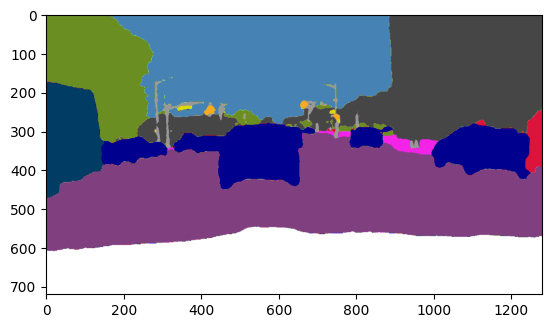

In [19]:
plt.imshow(colored_mask)

In [20]:
width, height

(1280, 720)

In [21]:
colored_mask.shape, img.shape

((720, 1280, 3), (720, 1280, 3))

In [22]:
colored_mask.dtype, img.dtype

(dtype('uint8'), dtype('uint8'))

In [23]:
alpha = 0.4

overlay = img.copy()

# Add the segmentation mask to the overlay with transparency
segmented_image = cv2.addWeighted(colored_mask, alpha, overlay, 1-alpha, 0, overlay)

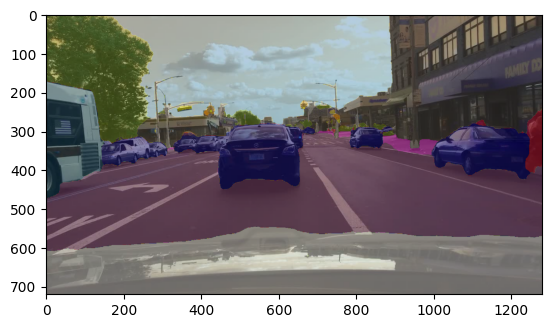

In [24]:
plt.imshow(segmented_image)

In [25]:
# Save the image
success = cv2.imwrite('model2_result.jpg', segmented_image)
if not success:
    print("Error: Image not saved")